## Analysis of Stock Price Predictions using LSTM models

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
# from pandas_datareader import data as web
from datetime import datetime
import plotly.express as px
import seaborn as sns

In [3]:
def read_data_frame(stock_df):
    print(stock_df.head())
    print(stock_df.describe())

In [4]:
def plot_visualisation(stock_df):
    #Scatterplot of adjusted close price
    stock_df['Date'] = pd.to_datetime(stock_df['Date'])

    fig = px.scatter(stock_df, x = 'Date', y = 'Adj Close')


    fig.show()

    #Plotting correlation plot

    float_df = stock_df.select_dtypes(exclude = "object")
    corr = float_df.corr()
    ax = plt.axes()
    sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, annot=True, cmap=sns.diverging_palette(220, 20, as_cmap=True), ax = ax)

    ax.set_title("Correlation of various features")
    plt.show()


In [7]:
#pulling of google data from csv file
stock_df = pd.read_csv('C:/Users/rkt98/Jupyter notebook/Stock price prediction by LSTM/google_stocks_data.csv')

In [8]:
read_data_frame(stock_df)

         Date        High         Low        Open       Close     Volume  \
0  2010-08-31  227.662659  224.224228  225.280273  225.235229  3889700.0   
1  2010-09-01  232.702698  226.476471  227.717712  230.395401  6450100.0   
2  2010-09-02  232.447449  230.385391  231.651657  231.821823  3365000.0   
3  2010-09-03  236.176178  233.953949  235.495499  235.385391  5075700.0   
4  2010-09-07  234.029022  231.741745  232.482483  232.432434  3416300.0   

    Adj Close  
0  225.235229  
1  230.395401  
2  231.821823  
3  235.385391  
4  232.432434  
              High          Low         Open        Close        Volume  \
count  2518.000000  2518.000000  2518.000000  2518.000000  2.518000e+03   
mean    733.985784   720.747161   727.523444   727.656434  3.081478e+06   
std     364.542195   357.096315   360.702224   361.132235  2.434145e+06   
min     227.662659   224.224228   225.280273   225.235229  5.206000e+05   
25%     398.523529   392.369873   396.502747   395.992249  1.516550e+06 

In [9]:
stock_df.head()

,Date,High,Low,Open,Close,Volume,Adj Close
0,2010-08-31,227.662659,224.224228,225.280273,225.235229,3889700.0,225.235229
1,2010-09-01,232.702698,226.476471,227.717712,230.395401,6450100.0,230.395401
2,2010-09-02,232.447449,230.385391,231.651657,231.821823,3365000.0,231.821823
3,2010-09-03,236.176178,233.953949,235.495499,235.385391,5075700.0,235.385391
4,2010-09-07,234.029022,231.741745,232.482483,232.432434,3416300.0,232.432434


C:\Users\rkt98\AppData\Local\Temp\ipykernel_18868\1964742773.py:13: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.



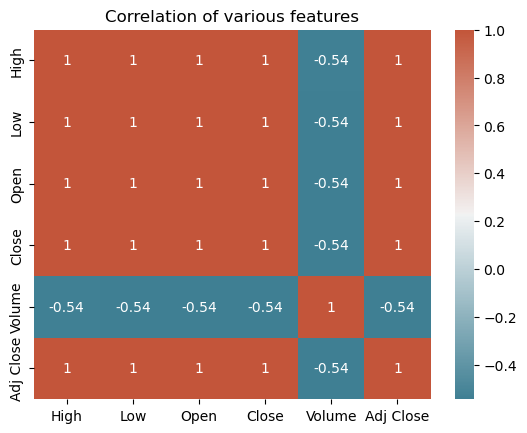

In [11]:
plot_visualisation(stock_df)

In [21]:
# !pip install finta
# !pip install tensorflow
# !pip install keras
import pandas as pd
import matplotlib.pyplot as plt
# from pandas_datareader import data as web
from datetime import datetime
from sklearn import preprocessing
import numpy as np
from finta import TA
import keras
import tensorflow as tf
from keras.models import Model
from keras.layers import Dense, Dropout, LSTM, Input, Activation, concatenate
from keras import optimizers
from keras.callbacks import History 
from sklearn.metrics import mean_squared_error
import numpy as np

  Obtaining dependency information for tensorflow from https://files.pythonhosted.org/packages/80/6f/57d36f6507e432d7fc1956b2e9e8530c5c2d2bfcd8821bcbfae271cd6688/tensorflow-2.14.0-cp311-cp311-win_amd64.whl.metadata
  Obtaining dependency information for tensorflow-intel==2.14.0 from https://files.pythonhosted.org/packages/ad/6e/1bfe367855dd87467564f7bf9fa14f3b17889988e79598bc37bf18f5ffb6/tensorflow_intel-2.14.0-cp311-cp311-win_amd64.whl.metadata
  Obtaining dependency information for absl-py>=1.0.0 from https://files.pythonhosted.org/packages/01/e4/dc0a1dcc4e74e08d7abedab278c795eef54a224363bb18f5692f416d834f/absl_py-2.0.0-py3-none-any.whl.metadata
  Obtaining dependency information for flatbuffers>=23.5.26 from https://files.pythonhosted.org/packages/6f/12/d5c79ee252793ffe845d58a913197bfa02ae9a0b5c9bc3dc4b58d477b9e7/flatbuffers-23.5.26-py2.py3-none-any.whl.metadata
     ---------------------------------------- 0.0/57.5 kB ? eta -:--:--
     ---------------------------------------- 0.0/

In [22]:
def on_balance_volume_creation(stock_df):
    # Adding of on balance volume to dataframe
    
    new_df = pd.DataFrame({})

    new_df = stock_df[['Adj Close']].copy()


    new_balance_volume = [0]
    tally = 0

    for i in range(1, len(new_df)):
        if (stock_df['Adj Close'][i] > stock_df['Adj Close'][i - 1]):
            tally += stock_df['Volume'][i]
        elif (stock_df['Adj Close'][i] < stock_df['Adj Close'][i - 1]):
            tally -= stock_df['Volume'][i]
        new_balance_volume.append(tally)

    new_df['On_Balance_Volume'] = new_balance_volume
    minimum = min(new_df['On_Balance_Volume'])

    new_df['On_Balance_Volume'] = new_df['On_Balance_Volume'] - minimum
    new_df['On_Balance_Volume'] = (new_df['On_Balance_Volume']+1).transform(np.log)

    return new_df

In [23]:
def add_technical_indicators(new_df):
    # Adding of technical indicators to data frame (Exponential moving average and Bollinger Band)
    edited_df = pd.DataFrame()

    edited_df['open'] = stock_df['Open']
    edited_df['high'] = stock_df['High']
    edited_df['low'] = stock_df['Low']
    edited_df['close'] = stock_df['Close']
    edited_df['volume'] = stock_df['Volume']
    edited_df.head()

    ema = TA.EMA(edited_df)
    bb = TA.BBANDS(edited_df)

    new_df['Exponential_moving_average'] = ema.copy()

    new_df = pd.concat([new_df, bb], axis = 1)


    for i in range(19):
        new_df['BB_MIDDLE'][i] = new_df.loc[i, 'Exponential_moving_average']
    
        if i != 0:
            higher = new_df.loc[i, 'BB_MIDDLE'] + 2 * new_df['Adj Close'].rolling(i + 1).std()[i]
            lower = new_df.loc[i, 'BB_MIDDLE'] - 2 * new_df['Adj Close'].rolling(i + 1).std()[i]
            new_df['BB_UPPER'][i] = higher
            new_df['BB_LOWER'][i] = lower
        else:
            new_df['BB_UPPER'][i] = new_df.loc[i, 'BB_MIDDLE']
            new_df['BB_LOWER'][i] = new_df.loc[i, 'BB_MIDDLE']
    return new_df

In [24]:
def train_test_split_preparation(new_df, train_split):
    #Preparation of train test set.
    train_indices = int(new_df.shape[0] * train_split)

    train_data = new_df[:train_indices]
    test_data = new_df[train_indices:]

    test_data = test_data.reset_index()
    test_data = test_data.drop(columns = ['index'])

    normaliser = preprocessing.MinMaxScaler()
    train_normalised_data = normaliser.fit_transform(train_data)

    test_normalised_data = normaliser.transform(test_data)

    X_train = np.array([train_normalised_data[:,0:][i : i + history_points].copy() for i in range(len(train_normalised_data) - history_points)])

    y_train = np.array([train_normalised_data[:,0][i + history_points].copy() for i in range(len(train_normalised_data) - history_points)])
    y_train = np.expand_dims(y_train, -1)

    y_normaliser = preprocessing.MinMaxScaler()
    next_day_close_values = np.array([train_data['Adj Close'][i + history_points].copy() for i in range(len(train_data) - history_points)])
    next_day_close_values = np.expand_dims(next_day_close_values, -1)

    y_normaliser.fit(next_day_close_values)

     
    X_test = np.array([test_normalised_data[:,0:][i  : i + history_points].copy() for i in range(len(test_normalised_data) - history_points)])
    

    y_test = np.array([test_data['Adj Close'][i + history_points].copy() for i in range(len(test_data) - history_points)])
    
    y_test = np.expand_dims(y_test, -1)

    return X_train, y_train, X_test, y_test, y_normaliser

In [25]:
def lstm_model(X_train, y_train, history_points):
    tf.random.set_seed(20)
    np.random.seed(10)
    lstm_input = Input(shape=(history_points, 6), name='lstm_input')

    inputs = LSTM(21, name='first_layer')(lstm_input)
    inputs = Dense(1, name='dense_layer')(inputs)
    output = Activation('linear', name='output')(inputs)

    model = Model(inputs=lstm_input, outputs=output)
    adam = optimizers.Adam(lr = 0.0008)
    model.compile(optimizer=adam, loss='mse')
    model.fit(x=X_train, y=y_train, batch_size=15, epochs=170, shuffle=True, validation_split = 0.1)

    return model

In [26]:
train_split = 0.7
history_points = 21
new_df = on_balance_volume_creation(stock_df)
new_df = add_technical_indicators(new_df)
X_train, y_train, X_test, y_test, y_reverse_normaliser = train_test_split_preparation(new_df, train_split)

In [27]:
model = lstm_model(X_train, y_train, history_points)

Epoch 1/170
105/105 [==============================] - 7s 12ms/step - loss: 0.0130 - val_loss: 0.0048
Epoch 2/170
105/105 [==============================] - 1s 7ms/step - loss: 9.3924e-04 - val_loss: 0.0024
Epoch 3/170
105/105 [==============================] - 1s 7ms/step - loss: 8.8242e-04 - val_loss: 0.0050
Epoch 4/170
105/105 [==============================] - 1s 7ms/step - loss: 8.3036e-04 - val_loss: 0.0018
Epoch 5/170
105/105 [==============================] - 1s 7ms/step - loss: 8.0319e-04 - val_loss: 0.0022
Epoch 6/170
105/105 [==============================] - 1s 7ms/step - loss: 7.2098e-04 - val_loss: 0.0024
Epoch 7/170
105/105 [==============================] - 1s 7ms/step - loss: 6.7848e-04 - val_loss: 0.0021
Epoch 8/170
105/105 [==============================] - 1s 7ms/step - loss: 6.4917e-04 - val_loss: 0.0017
Epoch 9/170
105/105 [==============================] - 1s 7ms/step - loss: 6.0710e-04 - val_loss: 0.0015
Epoch 10/170
105/105 [==============================] - 1s

105/105 [==============================] - 1s 7ms/step - loss: 1.3968e-04 - val_loss: 5.6206e-04
Epoch 77/170
105/105 [==============================] - 1s 7ms/step - loss: 1.1844e-04 - val_loss: 1.4050e-04
Epoch 78/170
105/105 [==============================] - 1s 7ms/step - loss: 1.1420e-04 - val_loss: 1.7121e-04
Epoch 79/170
105/105 [==============================] - 1s 7ms/step - loss: 1.2006e-04 - val_loss: 1.9301e-04
Epoch 80/170
105/105 [==============================] - 1s 7ms/step - loss: 1.2709e-04 - val_loss: 1.4501e-04
Epoch 81/170
105/105 [==============================] - 1s 7ms/step - loss: 1.2585e-04 - val_loss: 1.8293e-04
Epoch 82/170
105/105 [==============================] - 1s 7ms/step - loss: 1.1966e-04 - val_loss: 4.8638e-04
Epoch 83/170
105/105 [==============================] - 1s 7ms/step - loss: 1.3432e-04 - val_loss: 1.3531e-04
Epoch 84/170
105/105 [==============================] - 1s 7ms/step - loss: 1.1334e-04 - val_loss: 1.9871e-04
Epoch 85/170
105/105 [=

105/105 [==============================] - 1s 8ms/step - loss: 1.2325e-04 - val_loss: 1.3822e-04
Epoch 151/170
105/105 [==============================] - 1s 8ms/step - loss: 1.0726e-04 - val_loss: 2.3502e-04
Epoch 152/170
105/105 [==============================] - 1s 8ms/step - loss: 1.0673e-04 - val_loss: 1.5556e-04
Epoch 153/170
105/105 [==============================] - 1s 7ms/step - loss: 1.1322e-04 - val_loss: 5.0114e-04
Epoch 154/170
105/105 [==============================] - 1s 7ms/step - loss: 1.1503e-04 - val_loss: 3.4364e-04
Epoch 155/170
105/105 [==============================] - 1s 7ms/step - loss: 1.1480e-04 - val_loss: 1.4234e-04
Epoch 156/170
105/105 [==============================] - 1s 8ms/step - loss: 1.1767e-04 - val_loss: 1.3641e-04
Epoch 157/170
105/105 [==============================] - 1s 10ms/step - loss: 1.0655e-04 - val_loss: 1.4084e-04
Epoch 158/170
105/105 [==============================] - 1s 9ms/step - loss: 1.1701e-04 - val_loss: 3.4520e-04
Epoch 159/170


In [29]:
y_pred = model.predict(X_test)
y_pred = y_reverse_normaliser.inverse_transform(y_pred)

23/23 [==============================] - 3s 3ms/step


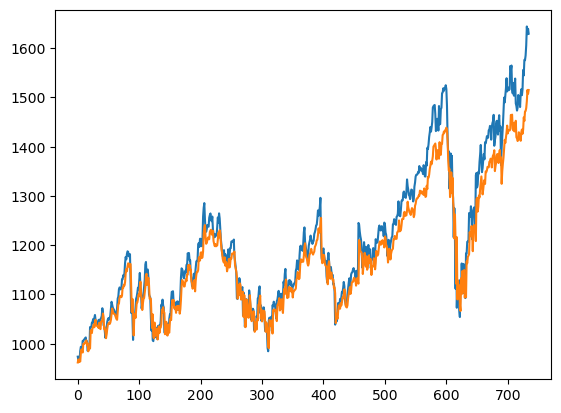

In [30]:
real = plt.plot(y_test, label='Actual Price')
pred = plt.plot(y_pred, label='Predicted Price')
plt.gcf().set_size_inches(12, 8, forward=True)
plt.title('Plot of real price and predicted price against number of days')
plt.xlabel('Number of days')
plt.ylabel('Adjusted Close Price($)')
plt.legend(['Actual Price', 'Predicted Price'])
print(mean_squared_error(y_test, y_pred))
plt.show()  

In [35]:
print(mean_squared_error(y_test, y_pred))

1737.752948283698


## magnitude_model

In [41]:
def on_balance_volume_creation2(stock_df):
    # Adding of on balance volume to dataframe
    
    new_df = pd.DataFrame({})

    new_df = stock_df[['Adj Close']].copy()


    new_balance_volume = [0]
    tally = 0

    #Adding the volume if the 
    for i in range(1, len(new_df)):
        if (stock_df['Adj Close'][i] > stock_df['Adj Close'][i - 1]):
            tally += stock_df['Volume'][i]
        elif (stock_df['Adj Close'][i] < stock_df['Adj Close'][i - 1]):
            tally -= stock_df['Volume'][i]
        new_balance_volume.append(tally)

    new_df['On_Balance_Volume'] = new_balance_volume
    minimum = min(new_df['On_Balance_Volume'])

    new_df['On_Balance_Volume'] = new_df['On_Balance_Volume'] - minimum
    new_df['On_Balance_Volume'] = (new_df['On_Balance_Volume']+1).transform(np.log)

    return new_df

In [42]:
def add_technical_indicators2(new_df):
    # Adding of technical indicators to data frame (Exponential moving average and Bollinger Band)
    edited_df = pd.DataFrame()

    #edited_df is made in order to generate the order needed for the finta library
    edited_df['open'] = stock_df['Open']
    edited_df['high'] = stock_df['High']
    edited_df['low'] = stock_df['Low']
    edited_df['close'] = stock_df['Close']
    edited_df['volume'] = stock_df['Volume']
    edited_df.head()

    ema = TA.EMA(edited_df)
    bb = TA.BBANDS(edited_df)

    new_df['Exponential_moving_average'] = ema.copy()

    #Adding of features to the dataframe
    new_df = pd.concat([new_df, bb], axis = 1)

    #Filling of missing data as Bollinger Bands is based on a 21 day EMA

    for i in range(19):
        new_df['BB_MIDDLE'][i] = new_df.loc[i, 'Exponential_moving_average']
    
        if i != 0:
            higher = new_df.loc[i, 'BB_MIDDLE'] + 2 * new_df['Adj Close'].rolling(i + 1).std()[i]
            lower = new_df.loc[i, 'BB_MIDDLE'] - 2 * new_df['Adj Close'].rolling(i + 1).std()[i]
            new_df['BB_UPPER'][i] = higher
            new_df['BB_LOWER'][i] = lower
        else:
            new_df['BB_UPPER'][i] = new_df.loc[i, 'BB_MIDDLE']
            new_df['BB_LOWER'][i] = new_df.loc[i, 'BB_MIDDLE']
    return new_df

In [43]:
def train_test_split_preparation2(new_df, train_split):
    new_df = new_df.loc[1:]
    #Preparation of train test set.
    train_indices = int(new_df.shape[0] * train_split)

    train_data = new_df[:train_indices]
    test_data = new_df[train_indices:]

    test_data = test_data.reset_index()
    test_data = test_data.drop(columns = ['index'])

    #normalise the data
    # We do a fit_transform on the train_data in order to ensure that all trained data is scaled between 0 and 1. 
    # After that, we do a .transform on the test_data to transform the test data based on the normalisation of the trained data.

    normaliser = preprocessing.MinMaxScaler()
    train_normalised_data = normaliser.fit_transform(train_data)

    test_normalised_data = normaliser.transform(test_data)

    X_train = np.array([train_normalised_data[:,0:][i : i + history_points].copy() for i in range(len(train_normalised_data) - history_points)])

    y_train = np.array([train_normalised_data[:,0][i + history_points].copy() for i in range(len(train_normalised_data) - history_points)])

    #expand_dims is used to prepare the dataset for the LSTM model
    y_train = np.expand_dims(y_train, -1)

    y_normaliser = preprocessing.MinMaxScaler()
    next_day_close_values = np.array([train_data['Adj Close'][i + history_points].copy() for i in range(len(train_data) - history_points)])
    next_day_close_values = np.expand_dims(next_day_close_values, -1)

    #Fit a normaliser such that we can .inverse_fit later on the output
    y_normaliser.fit(next_day_close_values)

     
    X_test = np.array([test_normalised_data[:,0:][i  : i + history_points].copy() for i in range(len(test_normalised_data) - history_points)])
    

    y_test = np.array([test_data['Adj Close'][i + history_points].copy() for i in range(len(test_data) - history_points)])
    
    y_test = np.expand_dims(y_test, -1)

    return X_train, y_train, X_test, y_test, y_normaliser

In [44]:
def lstm_model2(X_train, y_train, history_points):
    tf.random.set_seed(20)
    np.random.seed(10)
    lstm_input = Input(shape=(history_points, 6), name='lstm_input')

    inputs = LSTM(21, name='first_layer')(lstm_input)
    inputs = Dense(16, name='first_dense_layer')(inputs)
    inputs = Dense(1, name='dense_layer')(inputs)
    output = Activation('linear', name='output')(inputs)

    model = Model(inputs=lstm_input, outputs=output)
    adam = optimizers.Adam(lr = 0.0008)

    model.compile(optimizer=adam, loss='mse')
    model.fit(x=X_train, y=y_train, batch_size=15, epochs=170, shuffle=True, validation_split = 0.1)

    return model


In [45]:
train_split = 0.7    
history_points = 21
#Addition of on balance volume, exponential moving average and bollinger bands.    
new_df = on_balance_volume_creation2(stock_df)
new_df = add_technical_indicators2(new_df)  

In [46]:
 #Train test split
X_train, y_train, X_test, y_test, y_reverse_normaliser = train_test_split_preparation2(new_df, train_split)
model = lstm_model2(X_train, y_train, history_points)

Epoch 1/170
105/105 [==============================] - 3s 11ms/step - loss: 0.0102 - val_loss: 0.0095
Epoch 2/170
105/105 [==============================] - 1s 7ms/step - loss: 8.9640e-04 - val_loss: 0.0026
Epoch 3/170
105/105 [==============================] - 1s 7ms/step - loss: 7.5372e-04 - val_loss: 0.0047
Epoch 4/170
105/105 [==============================] - 1s 7ms/step - loss: 7.1333e-04 - val_loss: 0.0013
Epoch 5/170
105/105 [==============================] - 1s 7ms/step - loss: 6.3118e-04 - val_loss: 0.0016
Epoch 6/170
105/105 [==============================] - 1s 7ms/step - loss: 5.7100e-04 - val_loss: 0.0010
Epoch 7/170
105/105 [==============================] - 1s 7ms/step - loss: 5.1765e-04 - val_loss: 6.7127e-04
Epoch 8/170
105/105 [==============================] - 1s 7ms/step - loss: 5.1419e-04 - val_loss: 6.4395e-04
Epoch 9/170
105/105 [==============================] - 1s 7ms/step - loss: 4.4947e-04 - val_loss: 5.9689e-04
Epoch 10/170
105/105 [========================

Epoch 76/170
105/105 [==============================] - 1s 7ms/step - loss: 1.3241e-04 - val_loss: 1.5652e-04
Epoch 77/170
105/105 [==============================] - 1s 7ms/step - loss: 1.1814e-04 - val_loss: 2.0474e-04
Epoch 78/170
105/105 [==============================] - 1s 7ms/step - loss: 1.2668e-04 - val_loss: 1.6887e-04
Epoch 79/170
105/105 [==============================] - 1s 7ms/step - loss: 1.2306e-04 - val_loss: 1.6496e-04
Epoch 80/170
105/105 [==============================] - 1s 7ms/step - loss: 1.2178e-04 - val_loss: 2.6878e-04
Epoch 81/170
105/105 [==============================] - 1s 7ms/step - loss: 1.3224e-04 - val_loss: 3.1687e-04
Epoch 82/170
105/105 [==============================] - 1s 7ms/step - loss: 1.3467e-04 - val_loss: 1.3940e-04
Epoch 83/170
105/105 [==============================] - 1s 7ms/step - loss: 1.2854e-04 - val_loss: 6.2859e-04
Epoch 84/170
105/105 [==============================] - 1s 7ms/step - loss: 1.3548e-04 - val_loss: 5.2890e-04
Epoch 85/1

105/105 [==============================] - 1s 7ms/step - loss: 1.1325e-04 - val_loss: 3.4276e-04
Epoch 151/170
105/105 [==============================] - 1s 7ms/step - loss: 1.1206e-04 - val_loss: 4.1352e-04
Epoch 152/170
105/105 [==============================] - 1s 7ms/step - loss: 1.1776e-04 - val_loss: 2.4483e-04
Epoch 153/170
105/105 [==============================] - 1s 8ms/step - loss: 1.1380e-04 - val_loss: 1.5115e-04
Epoch 154/170
105/105 [==============================] - 1s 7ms/step - loss: 1.2974e-04 - val_loss: 1.4206e-04
Epoch 155/170
105/105 [==============================] - 1s 7ms/step - loss: 1.0988e-04 - val_loss: 2.7505e-04
Epoch 156/170
105/105 [==============================] - 1s 7ms/step - loss: 1.1684e-04 - val_loss: 1.4041e-04
Epoch 157/170
105/105 [==============================] - 1s 7ms/step - loss: 1.1163e-04 - val_loss: 1.8686e-04
Epoch 158/170
105/105 [==============================] - 1s 7ms/step - loss: 1.3073e-04 - val_loss: 1.4322e-04
Epoch 159/170
1

23/23 [==============================] - 1s 3ms/step
27.83420899780667


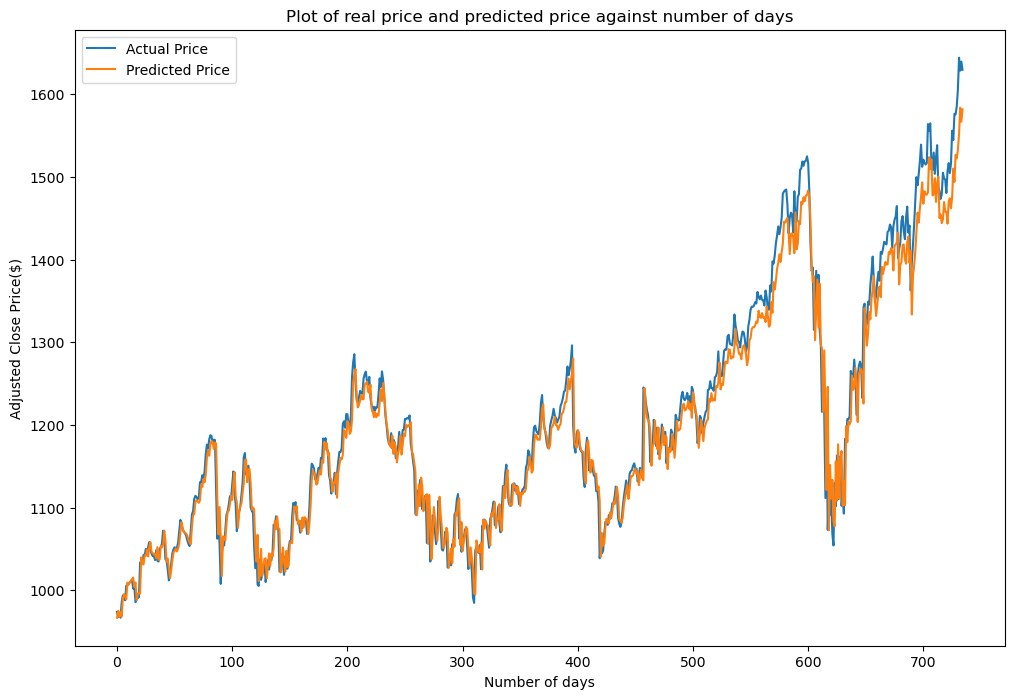

In [47]:
#Prediction of model, inverse transform to get back the scale of the y values 
y_pred = model.predict(X_test)
y_pred = y_reverse_normaliser.inverse_transform(y_pred)
real = plt.plot(y_test, label='Actual Price')
pred = plt.plot(y_pred, label='Predicted Price')
plt.gcf().set_size_inches(12, 8, forward=True)
plt.title('Plot of real price and predicted price against number of days')
plt.xlabel('Number of days')
plt.ylabel('Adjusted Close Price($)')
plt.legend(['Actual Price', 'Predicted Price'])
#Mean squared error
print(mean_squared_error(y_test, y_pred, squared = False))
plt.show()  